# **Big Data Computing AA 22/23 - Players Recommendation System**
The aim of this project is to build a players recommendation system which help football teams to find useful players according to their playing style.
The dataset used to address this task is the Soccer Event Match Dataset v5 collected from Wyscout data by Pappalardo et al. The dataset is publicly available on [figshare](https://figshare.com/collections/Soccer_match_event_dataset/4415000/5). The dataset contains data about season 2017/18 of Top 5 European Leagues (i.e. Serie A, Premier League, Bundesliga, Ligue 1, Liga), World Cup 2018 and Euro 2016.
Teams are users of the recommendation system and players are items. Users and items profile is build based on features based on event matches.
\
\
**References:** \
Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000.v5


# **Import Libraries**

In [ ]:
!pip install pyspark
!pip install matplotsoccer
!pip install socceraction==0.2.0
!pip install soccer_xg

  Using cached socceraction-0.2.0-py3-none-any.whl
  Attempting uninstall: socceraction
    Found existing installation: socceraction 0.2.1
    Uninstalling socceraction-0.2.1:
      Successfully uninstalled socceraction-0.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
soccer-xg 0.0.1 requires socceraction<0.3.0,>=0.2.1, but you have socceraction 0.2.0 which is incompatible.
  Using cached socceraction-0.2.1-py3-none-any.whl
  Attempting uninstall: socceraction
    Found existing installation: socceraction 0.2.0
    Uninstalling socceraction-0.2.0:
      Successfully uninstalled socceraction-0.2.0


In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# The following directive is to allow the inline visualization of generated plots
%matplotlib inline
import warnings
#import socceraction.vaep.features as features
#import socceraction.vaep.labels as labels
from tqdm.notebook import tqdm
import socceraction.spadl as spadl
import socceraction.spadl.wyscout as wyscout
from soccer_xg.api import DataApi
import soccer_xg.xg as xg
#import soccer_xg.features as fs
#from soccer_xg.utils import sample_temporal
warnings.filterwarnings('ignore')
import matplotsoccer
from pyspark.ml.linalg import Vectors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.ndimage import gaussian_filter
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

In [ ]:
import gc

gc.collect()

4

# **Setting Spark**

In [ ]:
# Create the session
#import os
#!apt install openjdk-8-jdk-headless -qq
#JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["JAVA_HOME"] = JAVA_HOME

conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("PlayerRecommendationSystem").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.app.name', 'PlayerRecommendationSystem'),
 ('spark.app.id', 'local-1687682934928'),
 ('spark.app.startTime', '1687682933550'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-

# **Import Dataset**

In [ ]:
from google.colab import drive
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BigDataProject_PlayerRecommendationSystem/Dataset"

drive.mount(GDRIVE_DIR, force_remount=True)


Mounted at /content/drive


In [ ]:
teams = spark.read.json(GDRIVE_DATA_DIR+'/teams.json')
club_teams = teams.filter(teams.type=='club')
club_teams.show(n=5)
print(f'The number of\033[1m teams\033[0m included in the dataset is {teams.count()}')
print(f'The number of\033[1m club teams\033[0m included in the dataset is {club_teams.count()}')

+--------------------+-------------------+--------------------+--------------------+----+----+
|                area|               city|                name|        officialName|type|wyId|
+--------------------+-------------------+--------------------+--------------------+----+----+
| {, XEN, 0, England}|Newcastle upon Tyne|    Newcastle United| Newcastle United FC|club|1613|
|{ES, ESP, 724, Sp...|               Vigo|       Celta de Vigo|Real Club Celta d...|club| 692|
|{ES, ESP, 724, Sp...|          Barcelona|            Espanyol|Reial Club Deport...|club| 691|
|{ES, ESP, 724, Sp...|    Vitoria-Gasteiz|Deportivo Alav\u0...|Deportivo Alav\u0...|club| 696|
|{ES, ESP, 724, Sp...|           Valencia|             Levante|          Levante UD|club| 695|
+--------------------+-------------------+--------------------+--------------------+----+----+
only showing top 5 rows

The number of teams included in the dataset is 142
The number of club teams included in the dataset is 98


In [ ]:
players = spark.read.json(GDRIVE_DATA_DIR+'/players.json')
players.show(n=5)
club_players = players.filter(players.currentTeamId.isNotNull())
print(f'The number of\033[1m players\033[0m included in the dataset is {players.count()}')
print(f'The number of\033[1m players\033[0m without a club team included in the dataset is {players.filter(players.currentTeamId.isNull()).count()}')
print(f'The number of\033[1m players\033[0m with a club team included in the dataset is {club_players.count()}')
club_players = club_players.withColumn('role_direct', club_players.role['code2'])
print(f'The number of\033[1m goalkeepers\033[0m included in the dataset is {club_players.filter(club_players.role_direct == "GK").count()}')
club_players = club_players.filter(club_players.role_direct != "GK")
print(f'The number of\033[1m players\033[0m considered in the dataset is {club_players.count()}')
club_players.show(n=5)

+--------------------+----------+---------------------+-------------+-----------------+-----+------+-----------+----------+--------------------+--------------------+--------------+------+------+
|           birthArea| birthDate|currentNationalTeamId|currentTeamId|        firstName| foot|height|   lastName|middleName|        passportArea|                role|     shortName|weight|  wyId|
+--------------------+----------+---------------------+-------------+-----------------+-----+------+-----------+----------+--------------------+--------------------+--------------+------+------+
|{TR, TUR, 792, Tu...|1989-06-17|                 4687|         4502|            Harun|right|   187|      Tekin|          |{TR, TUR, 792, Tu...|{GK, GKP, Goalkee...|      H. Tekin|    78| 32777|
|{FR, FRA, 250, Fr...|1999-01-23|                 4423|         3775|           Malang| left|   182|       Sarr|          |{SN, SEN, 686, Se...| {DF, DEF, Defender}|       M. Sarr|    73|393228|
|{FR, FRA, 250, Fr...|199

In [ ]:
competitions = spark.read.json(GDRIVE_DATA_DIR+'/competitions.json')
competitions = competitions.withColumn('name', competitions.area['name'])
competitions = competitions.filter(competitions.name != '')
competitions.show()
df_leagues = competitions.select(['name'])
leagues =[df_leagues.collect()[i]['name'] for i in range(df_leagues.count())]

+--------------------+---------------+-------+----+----+
|                area|         format|   name|type|wyId|
+--------------------+---------------+-------+----+----+
|{IT, ITA, 380, It...|Domestic league|  Italy|club| 524|
| {, XEN, 0, England}|Domestic league|England|club| 364|
|{ES, ESP, 724, Sp...|Domestic league|  Spain|club| 795|
|{FR, FRA, 250, Fr...|Domestic league| France|club| 412|
|{DE, DEU, 276, Ge...|Domestic league|Germany|club| 426|
+--------------------+---------------+-------+----+----+



In [ ]:
events_list = {}
matches_list = {}

for league in leagues:
    print(f'Fetching matches and events of {league} league')
    events_list[league] = pd.read_json(f'{GDRIVE_DATA_DIR}/events/events_{league}.json')
    matches_list[league] = pd.read_json(f'{GDRIVE_DATA_DIR}/matches/matches_{league}.json')
print(f'The number of\033[1m matches\033[0m included in the dataset is {np.array([len(x) for x in matches_list.values()]).sum()}')
print(f'The number of\033[1m events\033[0m included in the dataset is {np.array([len(x) for x in events_list.values()]).sum()}')

Fetching matches and events of Italy league
Fetching matches and events of Germany league
Fetching matches and events of England league
Fetching matches and events of France league
Fetching matches and events of Spain league
The number of matches included in the dataset is 1826
The number of events included in the dataset is 3071395


In [ ]:
matches_list['Italy'].head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406278,38,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",181248,2018-05-20 18:45:00,3161,,2576335,"Lazio - Internazionale, 2 - 3","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377206, 'role': 'referee'}, {'r...",Regular,524
1,Played,4406278,38,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",181248,2018-05-20 18:45:00,3158,MAPEI Stadium - Citt\u00e0 del Tricolore,2576336,"Sassuolo - Roma, 0 - 1","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377255, 'role': 'referee'}, {'r...",Regular,524
2,Played,4406278,38,"{'3173': {'scoreET': 0, 'coachId': 251044, 'si...",181248,2018-05-20 16:00:00,3173,,2576329,"Cagliari - Atalanta, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377247, 'role': 'referee'}, {'r...",Regular,524
3,Played,4406278,38,"{'3165': {'scoreET': 0, 'coachId': 272970, 'si...",181248,2018-05-20 16:00:00,3165,,2576330,"Chievo - Benevento, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377246, 'role': 'referee'}, {'r...",Regular,524
4,Played,4406278,38,"{'3166': {'scoreET': 0, 'coachId': 20481, 'sid...",181248,2018-05-20 16:00:00,3163,,2576331,"Udinese - Bologna, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377254, 'role': 'referee'}, {'r...",Regular,524


In [ ]:
print(events_list['Italy'].columns)
events_list['Italy'].head()

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961


#**Exploratory Data Analysis and Data Engineering**

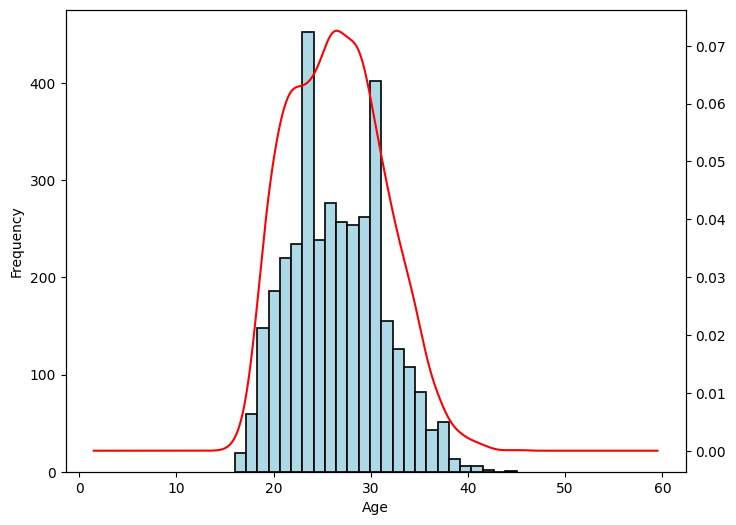

In [ ]:
last_matches_date = [x.select(pyspark.sql.functions.max(x.dateutc)).first()['max(dateutc)'] for x in matches_list]
referring_date = np.max(np.array(last_matches_date, dtype=object))
players = players.withColumn('referring_date',pyspark.sql.functions.lit(referring_date))
ages = players.select(players.lastName,round(pyspark.sql.functions.datediff(players.referring_date, players.birthDate)/365))
ages = ages.toPandas()
ages.rename(columns = {'round((datediff(referring_date, birthDate) / 365), 0)':'age'}, inplace = True)

fig, ax = plt.subplots(1,1, figsize=(8,6))
_ = ages.age.plot.hist(ax=ax, bins=25, color="lightblue", edgecolor='black', linewidth=1.2)
_ = ages.age.plot.density(ax=ax, secondary_y=True, color="red")
_ = ax.set_xlabel("Age")
_ = ax.set_ylabel("Frequency")

In [ ]:
df_events = pd.concat(events_list)
df_subevents = pd.DataFrame([ f"{df_events.iloc[i]['eventName'] } - {df_events.iloc[i]['subEventName']}" for i in range(len(df_events))], columns=['event_subevent'])
df_subevents['event_subevent'].value_counts()

Pass - Simple pass                                   1207448
Duel - Ground attacking duel                          265456
Duel - Ground defending duel                          264552
Others on the ball - Touch                            165296
Duel - Air duel                                       158186
Duel - Ground loose ball duel                         143861
Interruption - Ball out of the field                  129179
Pass - High pass                                      123214
Pass - Head pass                                       91194
Free Kick - Throw in                                   80305
Pass - Cross                                           58634
Others on the ball - Clearance                         53165
Foul - Foul                                            44293
Free Kick - Free Kick                                  43544
Pass - Launch                                          43303
Shot - Shot                                            40461
Free Kick - Goal kick   

<Axes: ylabel='wyId'>

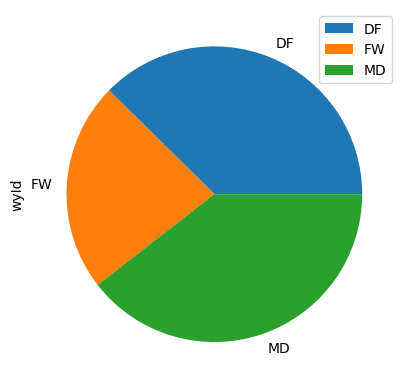

In [ ]:
club_players.toPandas().groupby('role_direct').count().plot.pie(y='wyId')

Distribution of players grouped by the role

Following cells convert the dataset into SPADL format which is a format that standardize data from different football providers.
\
**Reference:**
\
Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. “Actions speak louder than goals: Valuing player actions in soccer.” In Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, pp. 1851-1861. 2019.

In [ ]:
def determine_bodypart_id(event):
    """
    This function determines the body part used for an event
    Args:
    event (pd.Series): Wyscout event Series
    Returns:
    int: id of the body part used for the action
    """
    if event["subtype_id"] in [81, 36, 21, 90, 91]:
        body_part = "other"
    elif event["subtype_id"] == 82 or event['head/body']:
        body_part = "head"
    else:  # all other cases
        body_part = "foot"
    return spadl.config.bodyparts.index(body_part)
wyscout.determine_bodypart_id = determine_bodypart_id

In [ ]:
seasons = {
    181248: '1718',
    181150: '1718',
    181144: '1718',
    181189: '1718',
    181137: '1718'
}

df_teams = wyscout.convert_teams(club_teams.toPandas())
df_players = wyscout.convert_players(club_players.toPandas())
for league in leagues:

  df_matches = matches_list[league]
  season_id = seasons[df_matches.seasonId.unique()[0]]
  df_games =  wyscout.convert_games(df_matches)
  comp_id = league.upper()[:3]
  df_games['competition_id'] = comp_id
  df_games['season_id'] = season_id
  df_events = events_list[league].groupby('matchId', as_index=False)
  player_games = []
  spadl_h5 = os.path.join(GDRIVE_DATA_DIR, f"spadl-wyscout_{comp_id}-{season_id}.h5")
  print(spadl_h5)
  # Store all spadl data in h5-file
  print(f"Converting {comp_id} {season_id}")
  with pd.HDFStore(spadl_h5) as spadlstore:

        spadlstore["actiontypes"] = spadl.actiontypes_df()
        spadlstore["results"] = spadl.results_df()
        spadlstore["bodyparts"] = spadl.bodyparts_df()
        spadlstore["games"] = df_games

        for game in tqdm(list(df_games.itertuples())):
            game_id = game.game_id
            game_events = df_events.get_group(game_id)

            # filter the players that were lined up in this season
            player_games.append(wyscout.get_player_games(df_matches[df_matches.wyId == game_id].iloc[0], game_events))

            # convert events to SPADL actions
            home_team = game.home_team_id
            df_actions = wyscout.convert_actions(game_events, home_team)
            df_actions["action_id"] = range(len(df_actions))
            spadlstore[f"actions/game_{game_id}"] = df_actions

        player_games = pd.concat(player_games).reset_index(drop=True)
        spadlstore["player_games"] = player_games
        spadlstore["players"] = df_players[df_players.player_id.isin(player_games.player_id)]
        spadlstore["teams"] = df_teams[df_teams.team_id.isin(df_games.home_team_id) | df_teams.team_id.isin(df_games.away_team_id)]


/content/drive/MyDrive/BigDataProject_PlayerRecommendationSystem/Dataset/spadl-wyscout_ITA-1718.h5
Converting ITA 1718


  0%|          | 0/380 [00:00<?, ?it/s]

/content/drive/MyDrive/BigDataProject_PlayerRecommendationSystem/Dataset/spadl-wyscout_ENG-1718.h5
Converting ENG 1718


  0%|          | 0/380 [00:00<?, ?it/s]

/content/drive/MyDrive/BigDataProject_PlayerRecommendationSystem/Dataset/spadl-wyscout_SPA-1718.h5
Converting SPA 1718


  0%|          | 0/380 [00:00<?, ?it/s]

/content/drive/MyDrive/BigDataProject_PlayerRecommendationSystem/Dataset/spadl-wyscout_FRA-1718.h5
Converting FRA 1718


  0%|          | 0/380 [00:00<?, ?it/s]

/content/drive/MyDrive/BigDataProject_PlayerRecommendationSystem/Dataset/spadl-wyscout_GER-1718.h5
Converting GER 1718


  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
leagues = ['Italy', 'Germany', 'England','France','Spain']
api = DataApi([f"{GDRIVE_DATA_DIR}/spadl-wyscout_{l.upper()[:3]}-1718.h5" for l in leagues])
api_games = api.games
action_ids = {'dribble': 21, 'pass': 0, 'shot': 11, 'cross': 1, 'interception':10, 'clearance': 18}
api_teams = api.teams

In [ ]:
api_games.head()

,competition_id,season_id,game_date,home_team_id,away_team_id,db_path
game_id,,,,,,
2576338,ITA,1718,2018-05-20 13:00:00,3193,3185,/content/drive/MyDrive/BigDataProject_PlayerRe...
2576337,ITA,1718,2018-05-20 16:00:00,3204,3164,/content/drive/MyDrive/BigDataProject_PlayerRe...
2576336,ITA,1718,2018-05-20 18:45:00,3315,3158,/content/drive/MyDrive/BigDataProject_PlayerRe...
2576335,ITA,1718,2018-05-20 18:45:00,3162,3161,/content/drive/MyDrive/BigDataProject_PlayerRe...
2576334,ITA,1718,2018-05-19 13:00:00,3159,3194,/content/drive/MyDrive/BigDataProject_PlayerRe...


In [ ]:
api_teams.head()

,short_team_name,team_name,db_path
team_id,,,
19830,Monaco,AS Monaco FC,/content/drive/MyDrive/BigDataProject_PlayerRe...
10531,Swansea City,Swansea City AFC,/content/drive/MyDrive/BigDataProject_PlayerRe...
3804,Dijon,Dijon FCO,/content/drive/MyDrive/BigDataProject_PlayerRe...
3799,Angers,Angers SCO,/content/drive/MyDrive/BigDataProject_PlayerRe...
3795,Troyes,Esp\u00e9rance Sportive Troyes Aube Champagne,/content/drive/MyDrive/BigDataProject_PlayerRe...


In [ ]:
api_players = api.players
api_players.head()

,short_name,first_name,last_name,birth_date,db_path
player_id,,,,,
568583,Juan Cruz,Juan,Cruz Diaz Esp\u00f3sito,2000-04-25,/content/drive/MyDrive/BigDataProject_PlayerRe...
566942,E. Loiodice,Enzo,Loiodice,2000-11-27,/content/drive/MyDrive/BigDataProject_PlayerRe...
564512,S. Sanogo,Siriki,Sanogo,2001-12-21,/content/drive/MyDrive/BigDataProject_PlayerRe...
551398,David Alba,David,Alba Fern\u00e1ndez,1999-05-05,/content/drive/MyDrive/BigDataProject_PlayerRe...
545811,Hugo Duro,Hugo,Duro Perales,1999-11-10,/content/drive/MyDrive/BigDataProject_PlayerRe...


In [ ]:
api.player_games.head()

minutes_played  \
game_id team_id player_id                   
2576338 3193    413041           92.90082   
                349102           54.90082   
                345740           92.90082   
                206318           92.90082   
                116269           92.90082   

                                                                     db_path  
game_id team_id player_id                                                     
2576338 3193    413041     /content/drive/MyDrive/BigDataProject_PlayerRe...  
                349102     /content/drive/MyDrive/BigDataProject_PlayerRe...  
                345740     /content/drive/MyDrive/BigDataProject_PlayerRe...  
                206318     /content/drive/MyDrive/BigDataProject_PlayerRe...  
                116269     /content/drive/MyDrive/BigDataProject_PlayerRe...

Extract data about minutes played by each player in the whole dataset. The players who have played less than 900 minutes are excluded from analysis.

In [ ]:
api.get_actions(2576333).head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id
action_id,,,,,,,,,,,,
0,2576333.0,1.0,3.634273,3176.0,116170.0,52.50,32.64,68.25,38.76,0,0,1
1,2576333.0,1.0,4.255249,3176.0,424241.0,68.25,38.76,71.40,42.84,0,0,1
2,2576333.0,1.0,6.174719,3176.0,86328.0,71.40,42.84,26.25,4.08,0,0,1
3,2576333.0,1.0,8.822304,3176.0,26000.0,26.25,4.08,74.55,68.00,1,0,0
4,2576333.0,1.0,18.257540,3157.0,257028.0,27.30,0.00,45.15,4.08,2,2,0


In [ ]:
player_games = api.player_games
minutes_played = pd.DataFrame(player_games.groupby('player_id')['minutes_played'].sum())
minutes_played = minutes_played[minutes_played.minutes_played > 900]
players_minutes = club_players.toPandas().set_index('wyId').merge(minutes_played, how='left', left_index=True, right_index = True)
players_without_minutes = players_minutes[pd.isnull(players_minutes.minutes_played)]
players_minutes = players_minutes[pd.notnull(players_minutes.minutes_played)]
print(f'The number of\033[1m players\033[0m who have played less than 900 minutes in the dataset is {len(players_without_minutes)}')
print(f'The average number of\033[1m players\033[0m per teams who have played at least 900 minutes in the dataset is {len(players_minutes)/ len(api_teams)}')

The number of players who have played less than 900 minutes in the dataset is 1584
The average number of players per teams who have played at least 900 minutes in the dataset is 15.5


In [ ]:
players_minutes.head()

,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,role_direct,minutes_played
wyId,,,,,,,,,,,,,,,
393228,"(FR, FRA, 250, France)",1999-01-23,4423,3775,Malang,left,182,Sarr,,"(SN, SEN, 686, Senegal)","(DF, DEF, Defender)",M. Sarr,73,DF,1379.615269
32793,"(FR, FRA, 250, France)",1990-03-06,19314,683,Alfred John Momar,right,187,N'Diaye,,"(SN, SEN, 686, Senegal)","(MD, MID, Midfielder)",A. N'Diaye,82,MD,108.314618
393247,"(FR, FRA, 250, France)",1999-05-25,null,2975,Ibrahima,right,192,Konat\u00e9,,"(FR, FRA, 250, France)","(DF, DEF, Defender)",I. Konat\u00e9,84,DF,1267.693653
36,"(BE, BEL, 56, Belgium)",1989-03-02,5629,1624,Toby,right,187,Alderweireld,,"(BE, BEL, 56, Belgium)","(DF, DEF, Defender)",T. Alderweireld,91,DF,1238.400194
48,"(BE, BEL, 56, Belgium)",1987-04-24,5629,1624,Jan,left,189,Vertonghen,,"(BE, BEL, 56, Belgium)","(DF, DEF, Defender)",J. Vertonghen,88,DF,3344.850202


In [ ]:
def max_str(str1: str, str2: str) -> str:
  return str1 if str1 >= str2 else str2


#compute for each team number of appearances for each player
game_ids = list(api_games.index.unique())
team_player = {}

for id in tqdm(game_ids, total=len(game_ids)):
  df_actions = api.get_actions(id)
  home, away = api.get_home_away_team_id(id)
  game_date = api_games[api_games.index == id]['game_date'].unique()[0][:10]
  home_players = set(df_actions[df_actions.team_id == home].player_id.unique())
  away_players = set(df_actions[df_actions.team_id == away].player_id.unique())
  try:
    home_players.remove(0)
    away_players.remove(0)
  except:
    continue
  if home not in team_player.keys():
    team_player[home] = {p: [1,game_date] for p in home_players}
  else:
    #print(game_date, team_player[home][p][1], max_str(game_date, team_player[home][p][1]))
    for p in home_players:
      team_player[home][p] = [team_player[home][p][0] +1, max_str(game_date, team_player[home][p][1])] if p in team_player[home].keys() else [1,game_date]

  if away not in team_player.keys():
    team_player[away] = {p: [1,game_date] for p in away_players}
  else:
    for p in away_players:
      team_player[away][p] = [team_player[away][p][0]+1,max_str(game_date, team_player[away][p][1])] if p in team_player[away].keys() else [1, game_date]

  0%|          | 0/1826 [00:00<?, ?it/s]

In [ ]:
team_players_list = []
for k,pls in team_player.items():
  for pl, app in pls.items():
    team_players_list.append((k,pl,app[0],app[1]))
team_players_df = pd.DataFrame(team_players_list, columns=['team_id', 'player_id','appearances','last_match_day'])
team_players_df.to_json(GDRIVE_DATA_DIR+'team_player.json')
team_players_df_last = team_players_df.sort_values('last_match_day', ascending=False).drop_duplicates(subset=['player_id'])

In [ ]:
df_team_tmp = team_players_df_last.merge(club_players.toPandas(), left_on='player_id', right_on='wyId')
df_team_tmp['change_team'] = np.where(pd.to_numeric(df_team_tmp.currentTeamId,errors='coerce') != df_team_tmp.team_id,1,0)
df_player_transferred = df_team_tmp[(df_team_tmp.change_team == 1)]
print(f'The number of players who changed team at the end of the season is {len(df_player_transferred)}')
df_player_transferred.head()

The number of players who changed team at the end of the season is 352


,team_id,player_id,appearances,last_match_day,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId,role_direct,change_team
18,3163,21314.0,19,2018-05-20,"(IS, ISL, 352, Iceland)",1984-06-29,7839,3254,Emil,left,185,Hallfre\u00f0sson,,"(IS, ISL, 352, Iceland)","(MD, MID, Midfielder)",E. Hallfre\u00f0sson,83,21314,MD,1
63,3157,135927.0,23,2018-05-20,"(PT, PRT, 620, Portugal)",1995-11-06,9905,680,Andr\u00e9 Miguel,right,182,Valente Silva,,"(PT, PRT, 620, Portugal)","(FW, FWD, Forward)",Andr\u00e9 Silva,70,135927,FW,1
66,3157,354470.0,1,2018-05-20,"(IT, ITA, 380, Italy)",1999-03-16,27928,26542,Emanuele,right,180,Torrasi,,"(IT, ITA, 380, Italy)","(MD, MID, Midfielder)",E. Torrasi,0,354470,MD,1
126,677,516397.0,2,2018-05-20,"(ES, ESP, 724, Spain)",2000-03-14,null,859,Mujaid,,180,Sadick Aliu,,"(ES, ESP, 724, Spain)","(DF, DEF, Defender)",Mujaid Sadick,0,516397,DF,1
151,674,237034.0,32,2018-05-20,"(PT, PRT, 620, Portugal)",1996-11-29,9905,3767,Gon\u00e7alo Manuel,right,179,Ganchinho Guedes,,"(PT, PRT, 620, Portugal)","(FW, FWD, Forward)",Gon\u00e7alo Guedes,70,237034,FW,1


In [ ]:
#given a game id return the number of main actions for each team which have played it
def offensive_action_aggregated(game_id: int) -> dict:
  df_actions = api.get_actions(game_id)
  n_goals = pd.DataFrame(df_actions[(df_actions.type_id == action_ids['shot']) & (df_actions.result_id == 1)].groupby('team_id').count()['result_id']).rename(columns={'result_id': 'goals'}).T.to_dict()
  n_dribble = pd.DataFrame(df_actions[(df_actions.type_id == action_ids['dribble'])].groupby('team_id').count()['result_id']).rename(columns={'result_id': 'dribble'}).T.to_dict()
  n_pass = pd.DataFrame(df_actions[(df_actions.type_id == action_ids['pass'])].groupby('team_id').count()['result_id']).rename(columns={'result_id': 'pass'}).T.to_dict()
  n_cross = pd.DataFrame(df_actions[(df_actions.type_id == action_ids['cross'])].groupby('team_id').count()['result_id']).rename(columns={'result_id': 'cross'}).T.to_dict()
  n_shot = pd.DataFrame(df_actions[(df_actions.type_id == action_ids['shot'])].groupby('team_id').count()['result_id']).rename(columns={'result_id': 'shot'}).T.to_dict()
  d = {}
  for k in n_pass.keys():
    d[k] = n_pass[k]
    if k in n_goals.keys():
      d[k]['goals']=  n_goals[k]['goals']
    else:
      d[k]['goals'] = 0

    if k in n_cross.keys():
      d[k]['cross']=  n_cross[k]['cross']
    else:
      d[k]['cross'] = 0
    if k in n_shot.keys():
      d[k]['shot']=  n_shot[k]['shot']
    else:
      d[k]['shot'] = 0
    if k in n_dribble.keys():
      d[k]['dribble']=  n_dribble[k]['dribble']
    else:
      d[k]['dribble'] = 0

  return d

#modify in place d1, adding keys and values of d2
def merge_aggregated_dict(d1: dict, d2: dict) -> dict:
  for k, v in d2.items():
    if k in d1.keys():
      for action in v.keys():
        d1[k][action] = d1[k][action] + v[action]
    else:
      d1[k] = v
  return d1

In [ ]:
game_ids = list(api_games.index.unique())
d = {}
for id in tqdm(game_ids, total=len(game_ids)):
  merge_aggregated_dict(d,offensive_action_aggregated(id))

  0%|          | 0/1826 [00:00<?, ?it/s]

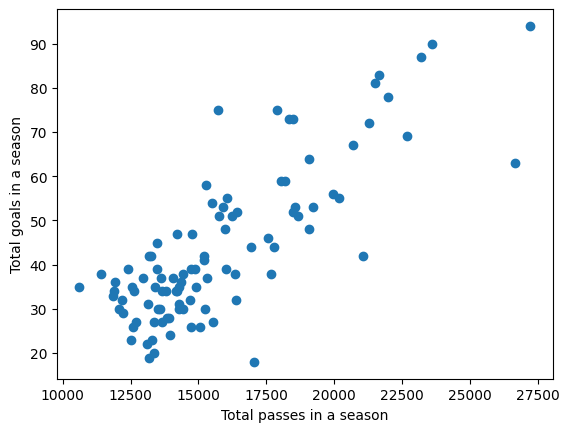

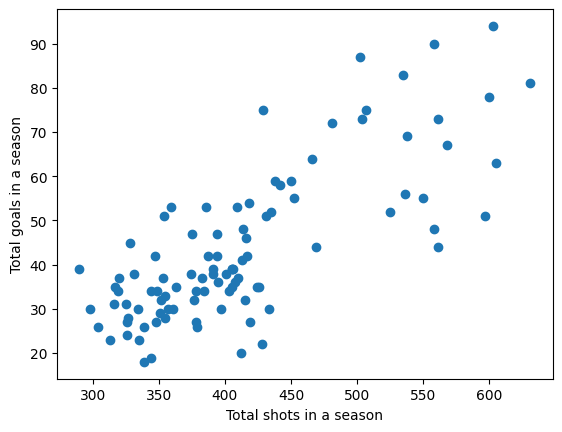

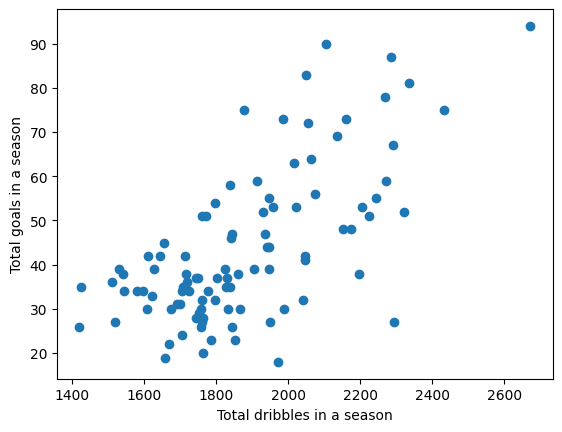

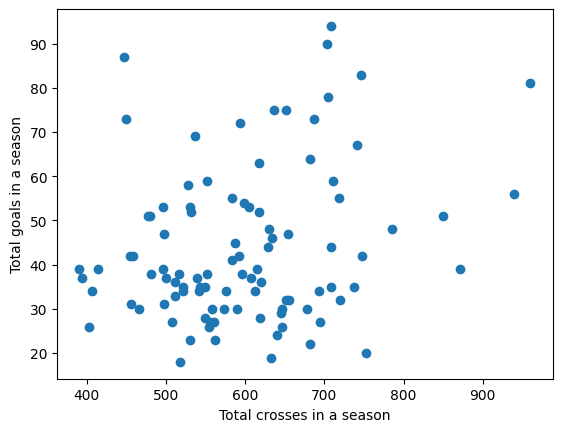

In [ ]:
df_agg = pd.DataFrame(d).T

plt.scatter(df_agg['pass'], df_agg['goals'])
plt.xlabel('Total passes in a season')
plt.ylabel('Total goals in a season')
plt.show()
plt.scatter(df_agg['shot'], df_agg['goals'])
plt.xlabel('Total shots in a season')
plt.ylabel('Total goals in a season')
plt.show()
plt.scatter(df_agg['dribble'], df_agg['goals'])
plt.xlabel('Total dribbles in a season')
plt.ylabel('Total goals in a season')
plt.show()
plt.scatter(df_agg['cross'], df_agg['goals'])
plt.xlabel('Total crosses in a season')
plt.ylabel('Total goals in a season')
plt.show()

As we can see in the plots above there are relations between the number of action played and the number of goals during a season. When the number of action increases then the number of goals increases. This relation is more soft with the number of crosses.

#**Building players' profiles: Player2Vec**

A heatmap is a summary of the locations where player *p* performs actions of type *t*. For each player and action type, we execute the following three steps:
\
**Counting**: We overlay a grid of size $23×53$ on the soccer field. Next, we
select all of player p’s actions of type t in our data set. Per grid cell $X_{ij}$ , we count the number of actions that started in that cell.
\
**Normalizing**:  Two players $p_1$ and $p_2$ can have an identical playing style, but if player $p_1$ played more minutes than player $p_2$, then player $p_1$’s matrix *X* will contain higher raw counts than the matrix of player $p_2$. To combat this, we normalize *X* such that each cell contains its count if *p* had played 90 minutes (1 game).
\
**Smoothing**:To promote smoothness in the counts of nearby cells, a Gaussian blur is applied to matrix $X'$.

Only open plays are considered: \
possession ball action (offensive) = {pass, dribble, cross, shot} \
difensive ball action (difensive) = {clearance, interception} \
\
**References:** \
Decroos, Tom & Davis, Jesse. (2020). Player Vectors: Characterizing Soccer Players’ Playing Style from Match Event Streams. 10.1007/978-3-030-46133-1_34. :

In [ ]:
def get_player_role(player: int) -> str:
  #GKs were previously excluded so there weren't in player_minutes dataframe
  try:
    return players_minutes[players_minutes.index == player].role_direct.unique()[0]
  except:
    return 'GK'

In [ ]:
def get_actions_type(df_actions: pd.DataFrame, id: int, action_type_id: int, away_team: int, is_team: bool = False) -> pd.DataFrame:

  if is_team:
    df_actions = df_actions[(df_actions.type_id == action_type_id) &  (df_actions.team_id == id)]
  else:
    df_actions = df_actions[(df_actions.type_id == action_type_id) &  (df_actions.player_id == id)]

  try:
    is_away = away_team == df_actions.team_id.unique()[0]
  except:
    is_away = False

  df_actions['start_x'] = np.round(df_actions.start_x) if not is_away else np.round(df_actions.start_x) *(-1) + 105
  df_actions['start_y'] = np.round(df_actions.start_y) if not is_away else np.round(df_actions.start_y) *(-1) + 68
  df_actions['end_x'] = np.round(df_actions.end_x) if not is_away else np.round(df_actions.end_x) *(-1) + 105
  df_actions['end_y'] = np.round(df_actions.end_y) if not is_away else np.round(df_actions.end_y) *(-1) + 68

  return df_actions

def drawing_heatmap(positions) -> None:
  import matplotsoccer
  from scipy.ndimage import gaussian_filter

  if type(positions == list):
    x = pd.Series([x[0] for x in positions])
    y = pd.Series([x[1] for x in positions])
  else:
    x = positions.start_x
    y = positions.start_y

  hm = matplotsoccer.count(x,y)
  hm = gaussian_filter(hm,1) # blur the heatmap
  matplotsoccer.heatmap(hm) # plot the heatmap

In [ ]:
#the function add counts of particular events of a match to heatmap
def building_heatmaps(heatmap:np.ndarray, df_actions: pd.DataFrame, start: bool = True) -> np.ndarray:
  if start:
    df_actions = df_actions.groupby(['start_x','start_y']).count()
  else:
    df_actions = df_actions.groupby(['end_x','end_y']).count()

  before = heatmap.sum()
  for idx, row in df_actions.iterrows():
    x, y = idx
    count = row['game_id']
    heatmap[int(y)][int(x)] += count
  after = heatmap.sum()
  if before != after and len(df_actions) == 0:
    print(f'attenzione: {before, after}')
  return heatmap

#start_heatmap = building_heatmaps(start_heatmap, df_actions)
#end_heatmap = building_heatmaps(end_heatmap, df_actions, False)

In [ ]:
#given an action and a list of games, compute heatmaps for each player who has played in those games
def action_heatmaps(action : int, game_ids: list) -> tuple[dict, dict]:
  start_heatmaps = {}
  end_heatmaps = {}
  for id in tqdm(game_ids, total=len(game_ids)):
    df_actions = api.get_actions(id)
    players_in_game = list(df_actions.player_id.unique())
    home, away = api.get_home_away_team_id(id)
    movement_player = [player for player in players_in_game if get_player_role(player) != 'GK']
    for player in movement_player:
        df_player_actions = get_actions_type(df_actions, player, action, away)
        if player not in start_heatmaps.keys():
          #football pitch is 105m x 68m
          start_heatmap = np.zeros((69,106),dtype=np.int8)
          end_heatmap = np.zeros((69,106), dtype=np.int8)
        else:
          start_heatmap = start_heatmaps[player]
          end_heatmap = end_heatmaps[player]

        start_heatmap = building_heatmaps(start_heatmap, df_player_actions)
        end_heatmap = building_heatmaps(end_heatmap, df_player_actions)

        start_heatmaps[player]= start_heatmap
        end_heatmaps[player]= end_heatmap

  return start_heatmaps, end_heatmaps

#given an action and a list of games, compute heatmaps for each team which has played in those games
def action_heatmaps_team(action : int, game_ids: list) -> tuple[dict, dict]:
  start_heatmaps = {}
  end_heatmaps = {}
  for id in tqdm(game_ids, total=len(game_ids)):
    df_actions = api.get_actions(id)
    home, away = api.get_home_away_team_id(id)

    df_player_actions = get_actions_type(df_actions, home, action, away,True)
    if home not in start_heatmaps.keys():
        #football pitch is 105m x 68m
        start_heatmap = np.zeros((69,106),dtype=np.int8)
        end_heatmap = np.zeros((69,106), dtype=np.int8)
    else:
        start_heatmap = start_heatmaps[home]
        end_heatmap = end_heatmaps[home]

    start_heatmap = building_heatmaps(start_heatmap, df_player_actions)
    end_heatmap = building_heatmaps(end_heatmap, df_player_actions, False)

    start_heatmaps[home]= start_heatmap
    end_heatmaps[home]= end_heatmap

    #repeat operation for away team
    df_player_actions = get_actions_type(df_actions, away, action, away,True)
    if away not in start_heatmaps.keys():
        #football pitch is 105m x 68m
        start_heatmap = np.zeros((69,106),dtype=np.int8)
        end_heatmap = np.zeros((69,106), dtype=np.int8)
    else:
        start_heatmap = start_heatmaps[away]
        end_heatmap = end_heatmaps[away]

    start_heatmap = building_heatmaps(start_heatmap, df_player_actions)
    end_heatmap = building_heatmaps(end_heatmap, df_player_actions, False)

    start_heatmaps[away]= start_heatmap
    end_heatmaps[away]= end_heatmap

  return start_heatmaps, end_heatmaps

#storing intermediate results of heatmaps to save memory and time
def heatmap_toPandas(heatmaps: dict, is_team: bool = False) -> pd.DataFrame:
  header = 'team' if is_team else 'player'
  players = list(heatmaps.keys())
  dfs_players = []
  for player in players:
    heatmap_player = heatmaps[player]
    '''
    for i in range(heatmap_player.shape[0]):
      player_out = {'player': player}
      player_out['index_list'] = i
      player_out['values'] = heatmap_player[i]
      player_out_list.append(player_out)
    '''
    #print(heatmap_player.shape, heatmap_player.reshape(-1).shape)
    player_out = {header: player, 'values': heatmap_player.reshape(23,3,53,2).sum(1).sum(2).reshape(-1)}
    dfs_players.append(pd.DataFrame([player_out]))
  return pd.concat(dfs_players)

Compute and store features heatmaps for any players into json files for each action

In [ ]:
#compute and store features heatmaps for any players into json files for each action
game_ids = list(api_games.index.unique())

#actions_done = ['dribble','pass','shot','cross','foul']
actions_done = []
for action in action_ids.keys():
  if action not in actions_done:
    print(action)
    start, end = action_heatmaps(action_ids[action], game_ids)
    start_hm = heatmap_toPandas(start)
    start_hm.reset_index().to_json(f'{GDRIVE_DATA_DIR}/{action}_start_heatmaps_v2.json')
    end_hm = heatmap_toPandas(end)
    end_hm.reset_index().to_json(f'{GDRIVE_DATA_DIR}/{action}_end_heatmaps_v2.json')

dribble


  0%|          | 0/1826 [00:00<?, ?it/s]

pass


  0%|          | 0/1826 [00:00<?, ?it/s]

shot


  0%|          | 0/1826 [00:00<?, ?it/s]

cross


  0%|          | 0/1826 [00:00<?, ?it/s]

interception


  0%|          | 0/1826 [00:00<?, ?it/s]

clearance


  0%|          | 0/1826 [00:00<?, ?it/s]

In [ ]:
#read json file produced in the precedent phase
def heatmaps_parsing(df: pd.DataFrame) -> dict:
  players_hm_parsing = {}
  for id, row in df.iterrows():
    players_hm_parsing[row['player']] = np.array(row['values'])
  return players_hm_parsing

#normalize heatmaps based on minutes played by a footballer
def heatmap_normalization(heatmaps: dict, df_minutes: pd.DataFrame) -> dict:
  from copy import deepcopy
  heatmaps = deepcopy(heatmaps)
  for player in heatmaps.keys():
    try:
      heatmaps[player] = (heatmaps[player] * 90)/ list(df_minutes[df_minutes.index == player]['minutes_played'])[0]
    except:
      pass
  return heatmaps


Let's see Lionel Messi heatmaps
dribble


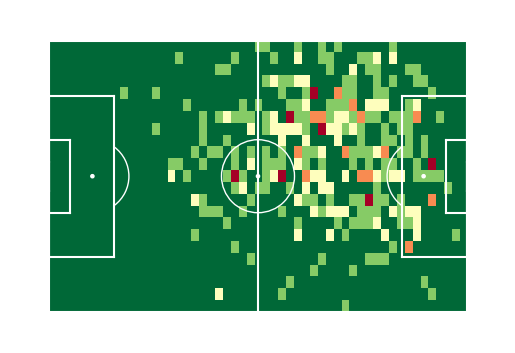

dribble normalized and smoothed by gaussian filter


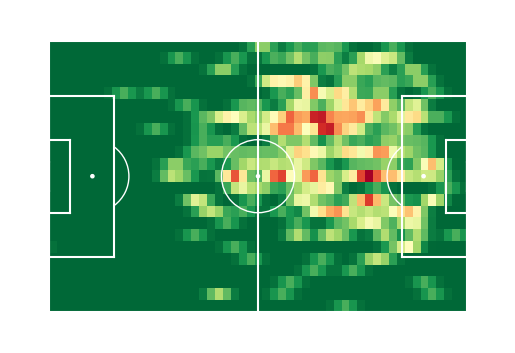

pass


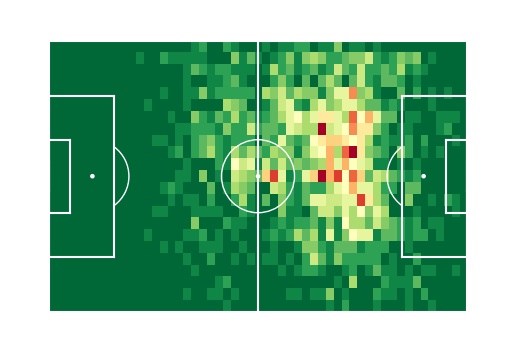

pass normalized and smoothed by gaussian filter


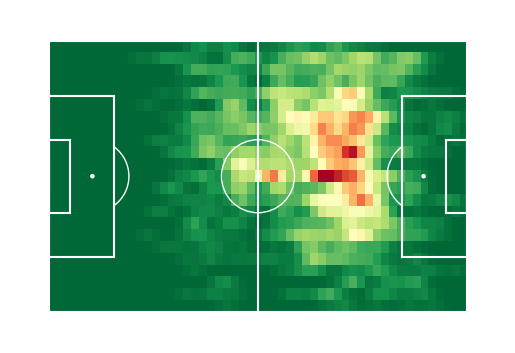

pass (end location)


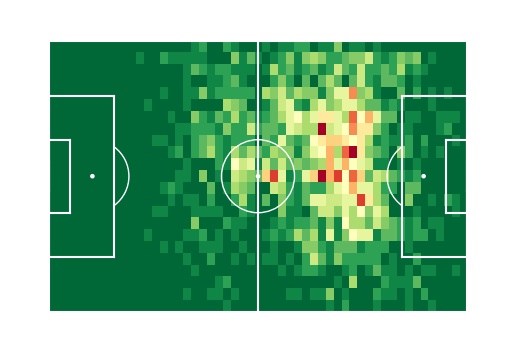

pass (end location) normalized and smoothed by gaussian filter


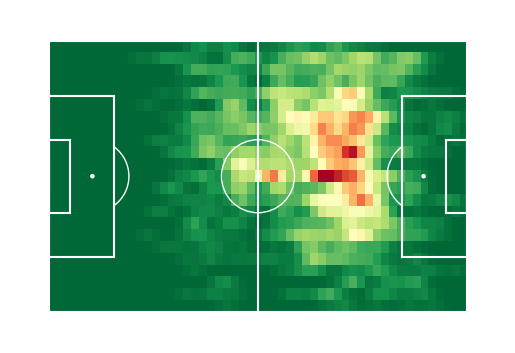

shot


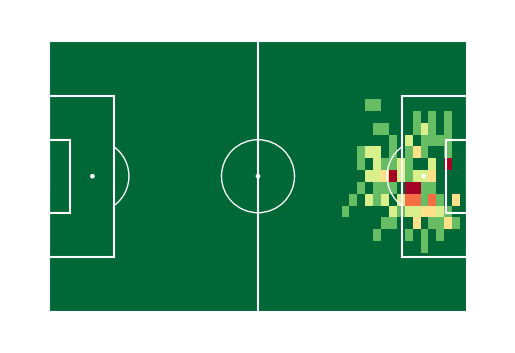

shot normalized and smoothed by gaussian filter


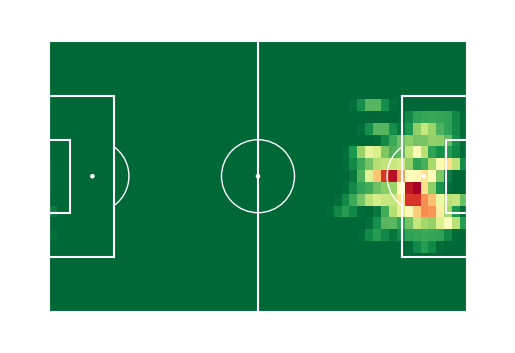

cross


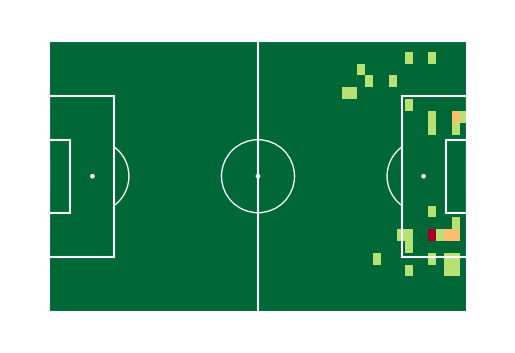

cross normalized and smoothed by gaussian filter


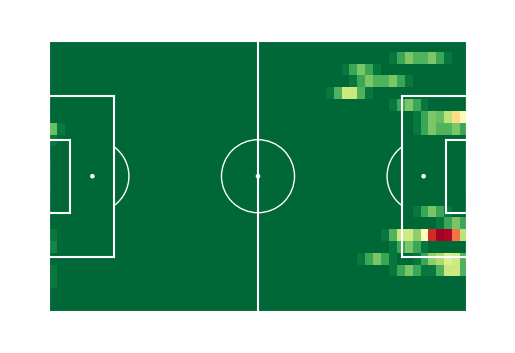

cross (end location)


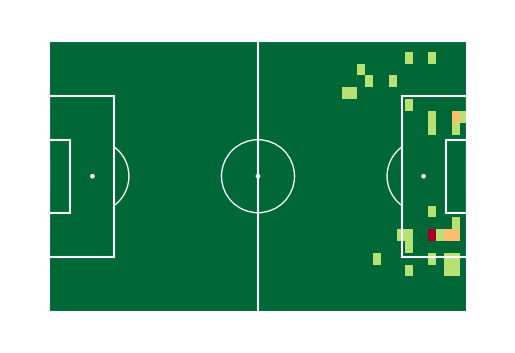

cross (end location) normalized and smoothed by gaussian filter


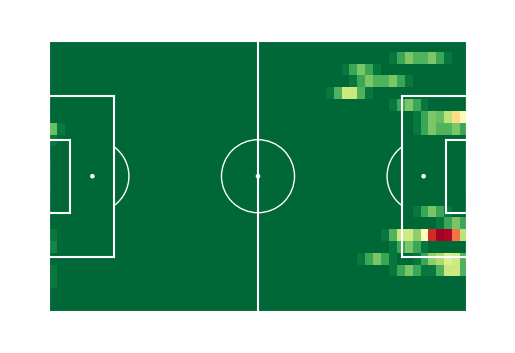

interception


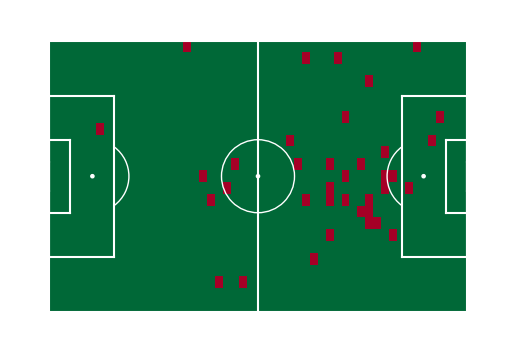

interception normalized and smoothed by gaussian filter


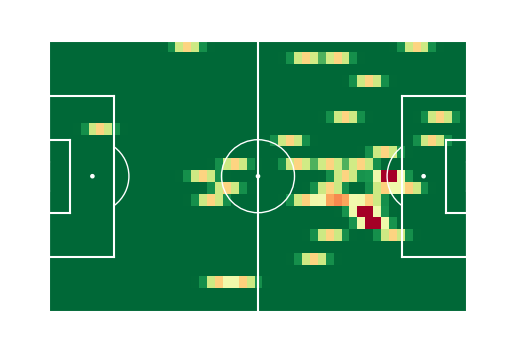

clearance


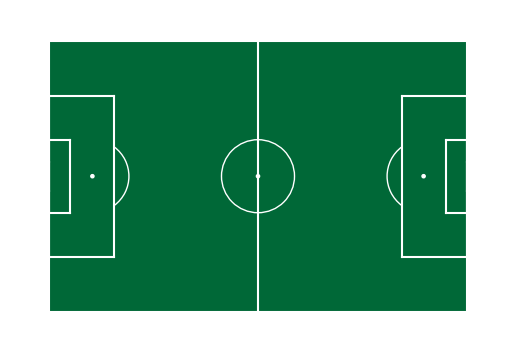

clearance normalized and smoothed by gaussian filter


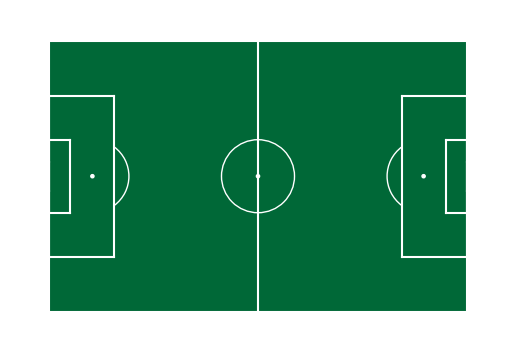

In [ ]:
print('Let\'s see Lionel Messi heatmaps')
for action in action_ids.keys():
  print(f'{action}')
  action_heatmaps_start = pd.read_json(f'{GDRIVE_DATA_DIR}/{action}_start_heatmaps_v2.json')
  hms_start = heatmaps_parsing(action_heatmaps_start)
  matplotsoccer.heatmap_green(hms_start[3359].reshape(23,53))
  hms_start_scaled = heatmap_normalization(hms_start, minutes_played)
  print(f'{action} normalized and smoothed by gaussian filter')
  hms_start_gaussian = {k: gaussian_filter(v,1) for k,v in hms_start_scaled.items()}
  matplotsoccer.heatmap_green(hms_start_gaussian[3359].reshape(23,53))
  if action in ['pass', 'cross']:
    action_heatmaps_end = pd.read_json(f'{GDRIVE_DATA_DIR}/{action}_end_heatmaps_v2.json')
    hms_end = heatmaps_parsing(action_heatmaps_end)
    print(f'{action} (end location)')
    matplotsoccer.heatmap_green(hms_end[3359].reshape(23,53))
    hms_end_scaled = heatmap_normalization(hms_end, minutes_played)
    print(f'{action} (end location) normalized and smoothed by gaussian filter')
    hms_end_gaussian = {k: gaussian_filter(v,1) for k,v in hms_end_scaled.items()}
    matplotsoccer.heatmap_green(hms_start_gaussian[3359].reshape(23,53))

For each action compute Principal Component Analysis (PCA) in order to encode player heatmaps in a vector of k element. The final embedding of a player is the concatenation of vectors obtained after PCA encoding. For cross and pass are consireded both start location heatmap and end location heatmap. More formally: \
$Player2Vec = \{k_{shot}, k_{dribble}, k_{pass}, k_{cross}, k_{clearance}, k_{interception} \}$

In [ ]:
action_k = {'dribble': 5, 'pass': 5, 'shot': 4, 'cross': 4, 'interception': 4, 'clearance': 4}

for action in action_ids.keys():
  print(f'{action} started')
  action_heatmaps_start = pd.read_json(f'{GDRIVE_DATA_DIR}/{action}_start_heatmaps_v2.json')
  hms_start = heatmaps_parsing(action_heatmaps_start)
  hms_start_scaled = heatmap_normalization(hms_start, minutes_played)
  hms_start_gaussian = {k: gaussian_filter(v,1) for k,v in hms_start_scaled.items()}
  if action in ['pass', 'cross']:
    action_heatmaps_end = pd.read_json(f'{GDRIVE_DATA_DIR}/{action}_end_heatmaps_v2.json')
    hms_end = heatmaps_parsing(action_heatmaps_end)
    hms_end_scaled = heatmap_normalization(hms_end, minutes_played)
    hms_end_gaussian = {k: gaussian_filter(v,1) for k,v in hms_end_scaled.items()}
    merged_hms_dr = {k: np.concatenate((hms_start_gaussian[k], hms_end_gaussian[k])) for k in hms_start.keys()}
    hms_dr_list = sorted(list(merged_hms_dr.items()), key= lambda x: x[0])
  else:
    hms_dr_list = sorted(list(hms_start_gaussian.items()), key= lambda x: x[0])

  k = action_k[action]
  hms_dr_list_to_df = [(float(hms_dr_list[i][0]), Vectors.dense(hms_dr_list[i][1].tolist()),) for i in range(len(hms_dr_list))]
  df_hms_spark = spark.createDataFrame(hms_dr_list_to_df,("player","features", ))

  scaler = StandardScaler(inputCol="features",
                        outputCol="std_features",
                        withStd=True, withMean=True)
  scalerModel = scaler.fit(df_hms_spark)
  df_hms_spark = scalerModel.transform(df_hms_spark)

  pca = PCA(k=k, inputCol="std_features", outputCol="pca")
  model = pca.fit(df_hms_spark)
  model.transform(df_hms_spark).toPandas().to_json(f'{GDRIVE_DATA_DIR}/pca_{action}_v2.json')
  model.save(f'{GDRIVE_DATA_DIR}/pca_{action}_v2')
  print(f'{action} over')

dribble started
dribble over
pass started
pass over
shot started
shot over
cross started
cross over
interception started
interception over
clearance started
clearance over


In [ ]:
def pca_decoding(action: str, is_team: bool) -> np.array:
  from pyspark.ml.feature import PCAModel
  if is_team:
    loaded_model = PCAModel.load(f'{GDRIVE_DATA_DIR}/pca_{action}_team')
    action_heatmaps_start = pd.read_json(f'{GDRIVE_DATA_DIR}/pca_pass_team.json')
  else:
    loaded_model = PCAModel.load(f'{GDRIVE_DATA_DIR}/pca_{action}')
    action_heatmaps_start = pd.read_json(f'{GDRIVE_DATA_DIR}/pca_{action}.json')

  ftr_np = np.stack([x for x in list(map(lambda x: x['array'],action_heatmaps_start.pca))],axis=0)
  return np.einsum('lk, kn -> ln', ftr_np, loaded_model.pc.toArray().T)


def pca_decoding_by_id(action_heatmaps_start: pd.DataFrame, id: int, action: str, is_team: bool = False) -> np.array:
  from pyspark.ml.feature import PCAModel
  pca_key = f'pca_{action}' if action != 'dribble' else 'pca'
  if is_team:
    loaded_model = PCAModel.load(f'{GDRIVE_DATA_DIR}/pca_{action}_team')
    ftr_np = np.array(action_heatmaps_start[action_heatmaps_start.team == id].iloc()[0][pca_key])[None,:]
  else:
    loaded_model = PCAModel.load(f'{GDRIVE_DATA_DIR}/pca_{action}_v2')
    ftr_np = np.array(action_heatmaps_start[action_heatmaps_start.player == id].iloc()[0][pca_key])[None,:]
  return np.einsum('lk, kn -> ln', ftr_np, loaded_model.pc.toArray().T)

In [ ]:
def draw_heatmaps_from_vector(player2vec: np.array) -> None:
  from pyspark.ml.feature import PCAModel
  from copy import deepcopy
  action_in_order = {'dribble':player2vec[:5],'pass': player2vec[5:10],'shot':player2vec[10:14],'cross':player2vec[14:18],'interception':player2vec[18:22],'clearance':player2vec[22:]}
  for action in action_in_order.keys():
      print(action)
      loaded_model = PCAModel.load(f'{GDRIVE_DATA_DIR}/pca_{action}_v2')

      if action not in ['pass','cross']:
        matplotsoccer.heatmap_green(np.einsum('lk, kn -> ln', action_in_order[action][None,:], loaded_model.pc.toArray().T).reshape(23,53))
      else:
        hms = np.einsum('lk, kn -> ln', action_in_order[action][None,:], loaded_model.pc.toArray().T).reshape(-1)
        hms_start = hms[:1219].reshape(23,53)
        matplotsoccer.heatmap_green(hms_start)


#**Building Teams' profiles**
For each team the profile is computed as the average of the vectors of the player who played for the team.

In [ ]:
#teams_pd = club_teams.select('officialName', 'wyId').toPandas()
club_players_pd = club_players.select('shortName','wyId','currentTeamId','role_direct').toPandas()

for action in action_ids.keys():
  #action_heatmaps_team = pd.read_json(f'{GDRIVE_DATA_DIR}/pca_{action}_team.json')[['team','pca', 'std_features']]
  #teams_pd = teams_pd.merge(action_heatmaps_team, left_on ='wyId', right_on='team', suffixes=('',f'_{action}'))
  action_heatmaps_player = pd.read_json(f'{GDRIVE_DATA_DIR}/pca_{action}_v2.json')[['player','pca','std_features']]
  club_players_pd = club_players_pd.merge(action_heatmaps_player, left_on ='wyId', right_on='player', suffixes=('',f'_{action}'))

pca_columns = [x for x in club_players_pd.columns if x.startswith('pca')]
std_columns = [x for x in club_players_pd.columns if x.startswith('std_features')]
for col in pca_columns:
  club_players_pd[col] = list(map(lambda x: np.array(x['array']), club_players_pd[col]))
  #teams_pd[col] = list(map(lambda x: np.array(x['array']), teams_pd[col]))

for col in std_columns:
  club_players_pd[col] = list(map(lambda x: np.array(x['array']), club_players_pd[col]))
  #teams_pd[col] = list(map(lambda x: np.array(x['array']), teams_pd[col]))

In [ ]:
club_players_pd = club_players_pd.merge(team_players_df, left_on='wyId', right_on='player_id')
print(f'The final number of items in the system is {len(club_players_pd.wyId.unique())}')

The final number of items in the system is 1519


In [ ]:
club_players_pd.head()

,shortName,wyId,currentTeamId,role_direct,player,pca,std_features,player_pass,pca_pass,std_features_pass,...,player_interception,pca_interception,std_features_interception,player_clearance,pca_clearance,std_features_clearance,team_id,player_id,appearances,last_match_day
0,M. Sarr,393228,3775,DF,393228,"[8.8541142659, -17.2089272061, 8.7399014341, 1...","[-0.056574560600000004, -0.0665869774, -0.0819...",393228,"[45.2905231641, 41.4062552967, 16.7923619762, ...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,393228,"[11.328097444800001, 12.2269466023, -5.8884141...","[-0.0938323591, -0.1303595589, -0.154677989700...",393228,"[1.5270113627000002, 5.6091120903, -1.00426377...","[-0.11551546530000001, -0.1344703143, -0.15367...",3775,393228.0,20,2018-04-28
1,I. Konat\u00e9,393247,2975,DF,393247,"[-5.3740123521, -8.0282374311, -0.9749176911, ...","[-0.056574560600000004, -0.0665869774, -0.0819...",393247,"[-24.3409897709, 24.9521076954, 6.3220403394, ...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,393247,"[-6.5561645514, 4.587556498, 0.1440705517, -2....","[-0.0938323591, -0.1303595589, -0.154677989700...",393247,"[-9.1044188402, -15.1789963991, -6.2819664241,...","[-0.11551546530000001, -0.1344703143, -0.15367...",2975,393247.0,13,2018-05-12
2,T. Alderweireld,36,1624,DF,36,"[-13.5171174063, -11.4046697729, 3.9407817087,...","[-0.056574560600000004, -0.0665869774, -0.0819...",36,"[-38.3443971548, 30.6530039069, 0.2182633668, ...","[-0.22078603530000002, -0.2955905996, -0.34615...",...,36,"[-7.5764503276, 3.5530032677, -0.430703598, -3...","[-0.0938323591, -0.1303595589, -0.154677989700...",36,"[-4.0554790072, -5.7273971614, 1.2023622199, 0...","[-0.11551546530000001, -0.1344703143, -0.15367...",1624,36.0,14,2018-05-13
3,J. Vertonghen,48,1624,DF,48,"[10.5944331752, -11.8809754578, 0.6810981425, ...","[-0.056574560600000004, -0.0665869774, -0.0819...",48,"[38.6470918454, 31.6582007351, 1.969355745, 18...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,48,"[9.822483621, 6.5005086811, 0.6490301463, 0.19...","[-0.0938323591, -0.1303595589, -0.154677989700...",48,"[-6.7491120627, 7.4039647862, 0.11629633660000...","[-0.11551546530000001, -0.1344703143, -0.15367...",1624,48.0,34,2018-05-09
4,A. Djiku,229427,3783,DF,229427,"[5.6162001734, -10.5907216144, 0.0449113143000...","[-0.056574560600000004, -0.0665869774, -0.0819...",229427,"[23.6103425349, 21.8306192502, 11.938832112, 1...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,229427,"[11.6024314166, 11.3316214163, -1.3960562715, ...","[-0.0938323591, -0.1303595589, -0.154677989700...",229427,"[-13.4203021681, 12.9960346309, 0.867819269000...","[-0.11551546530000001, -0.1344703143, -0.15367...",3783,229427.0,23,2018-05-19


In [ ]:
player_vectors = {}
for _, row in tqdm(club_players_pd.iterrows(), total=len(club_players_pd)):
  pca_vectors = []
  std_vectors = []
  pca_decoded_vectors=[]
  pca_dict = {}
  for pca in pca_columns:
    pca_key = 'pca_dribble' if pca == 'pca' else pca
    pca_vectors.append(row[pca])
    pca_dict[pca_key] = row[pca]
  for std in std_columns:
    std_key = 'std_features_dribble' if pca == 'std_features' else std
    std_vectors.append(row[std])
    pca_dict[std_key] = row[std]

  for action in action_ids.keys():
    p = pca_decoding_by_id(club_players_pd, row['wyId'], action).reshape(-1)
    pca_dict[f'pca_heatmap_{action}'] = p
    pca_decoded_vectors.append(p)

  pca_dict['pca_feature_vector'] = np.concatenate(pca_vectors)
  pca_dict['std_fea#ture_vector'] = np.concatenate(std_vectors)
  pca_dict['pca_decoded_vector'] = np.concatenate(pca_decoded_vectors)
  player_vectors[row['wyId']] = pca_dict

pd.DataFrame(player_vectors).to_json(GDRIVE_DATA_DIR+'/player_feature_vectors.json')

  0%|          | 0/1519 [00:00<?, ?it/s]

In [ ]:
team_players_df_last.head()

,team_id,player_id,appearances,last_match_day
0,3193,22883.0,14,2018-05-20
374,3163,20540.0,31,2018-05-20
399,3166,92908.0,15,2018-05-20
398,3166,373768.0,7,2018-05-20
397,3166,21123.0,32,2018-05-20


In [ ]:
df_players_vector_team = club_players_pd.merge(team_players_df_last, left_on ='wyId',right_on='player_id')
df_players_vector_team['change_team'] = np.where(pd.to_numeric(df_players_vector_team.currentTeamId,errors='coerce') != df_players_vector_team.team_id,1,0)
print(f'The number of players who changed the team at the end of the season is {len(df_players_vector_team[df_players_vector_team.change_team == 1])}')#.head()#.iloc()[0]['currentTeamId']
df_players_vector_team['player_vector'] = [np.concatenate(df_players_vector_team.iloc()[i][['pca','pca_pass','pca_shot','pca_cross','pca_interception','pca_clearance']]) for i in range(len(df_players_vector_team))]
df_players_vector_team.head()

The number of players who changed the team at the end of the season is 116


,shortName,wyId,currentTeamId,role_direct,player,pca,std_features,player_pass,pca_pass,std_features_pass,...,std_features_interception,player_clearance,pca_clearance,std_features_clearance,team_id,player_id,appearances,last_match_day,change_team,player_vector
0,M. Sarr,393228,3775,DF,393228,"[8.8541142659, -17.2089272061, 8.7399014341, 1...","[-0.056574560600000004, -0.0665869774, -0.0819...",393228,"[45.2905231641, 41.4062552967, 16.7923619762, ...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",393228,"[1.5270113627000002, 5.6091120903, -1.00426377...","[-0.11551546530000001, -0.1344703143, -0.15367...",3775,393228.0,20,2018-04-28,0,"[8.8541142659, -17.2089272061, 8.7399014341, 1..."
1,I. Konat\u00e9,393247,2975,DF,393247,"[-5.3740123521, -8.0282374311, -0.9749176911, ...","[-0.056574560600000004, -0.0665869774, -0.0819...",393247,"[-24.3409897709, 24.9521076954, 6.3220403394, ...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",393247,"[-9.1044188402, -15.1789963991, -6.2819664241,...","[-0.11551546530000001, -0.1344703143, -0.15367...",2975,393247.0,13,2018-05-12,0,"[-5.3740123521, -8.0282374311, -0.9749176911, ..."
2,T. Alderweireld,36,1624,DF,36,"[-13.5171174063, -11.4046697729, 3.9407817087,...","[-0.056574560600000004, -0.0665869774, -0.0819...",36,"[-38.3443971548, 30.6530039069, 0.2182633668, ...","[-0.22078603530000002, -0.2955905996, -0.34615...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",36,"[-4.0554790072, -5.7273971614, 1.2023622199, 0...","[-0.11551546530000001, -0.1344703143, -0.15367...",1624,36.0,14,2018-05-13,0,"[-13.5171174063, -11.4046697729, 3.9407817087,..."
3,J. Vertonghen,48,1624,DF,48,"[10.5944331752, -11.8809754578, 0.6810981425, ...","[-0.056574560600000004, -0.0665869774, -0.0819...",48,"[38.6470918454, 31.6582007351, 1.969355745, 18...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",48,"[-6.7491120627, 7.4039647862, 0.11629633660000...","[-0.11551546530000001, -0.1344703143, -0.15367...",1624,48.0,34,2018-05-09,0,"[10.5944331752, -11.8809754578, 0.6810981425, ..."
4,A. Djiku,229427,3783,DF,229427,"[5.6162001734, -10.5907216144, 0.0449113143000...","[-0.056574560600000004, -0.0665869774, -0.0819...",229427,"[23.6103425349, 21.8306192502, 11.938832112, 1...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",229427,"[-13.4203021681, 12.9960346309, 0.867819269000...","[-0.11551546530000001, -0.1344703143, -0.15367...",3783,229427.0,23,2018-05-19,0,"[5.6162001734, -10.5907216144, 0.0449113143000..."


Compute teams' profiles considering every player in the final dataset

In [ ]:
team_vector = {}
player_vectors = {}
team_ids = set(df_players_vector_team.team_id.unique())
for id in tqdm(team_ids, total=len(team_ids)):
  team_vectors = df_players_vector_team[df_players_vector_team.team_id == id]
  for i, row in team_vectors.iterrows():
      if id not in team_vector.keys():
        team_vector[id] = row['player_vector']
      else:
        team_vector[id] = np.vstack((team_vector[id], row['player_vector']))
      player_vectors[ row['player_id']]= row['player_vector']
  team_vector[id] = np.mean(team_vector[id],axis=0)

  0%|          | 0/98 [00:00<?, ?it/s]

Dataset will be divided into train and test set. Train set will be used to compose team's profiles, test set to evaluate accuracy performance of the system.

In [ ]:
from sklearn.model_selection import train_test_split
team_vector_train = {}
team_vector_test = {}
for id in tqdm(team_ids, total=len(team_ids)):
  team_vectors = df_players_vector_team[df_players_vector_team.team_id == id]
  X_data = []
  y_data = []
  #roles = []
  for i, row in team_vectors.iterrows():
    X_data.append(row['player_vector'])
    y_data.append(row['wyId'])
    #roles.append(row['role_direct'])
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=1)
  team_vector_train[id] = np.mean(np.stack(X_train),axis=0)
  for j in range(len(X_test)):
    #dict_pl = {'team': 3157, 'player': y_test[j], 'vector': X_test[j]}
    team_vector_test[y_test[j]] = {'team': id, 'vector': X_test[j]}

  0%|          | 0/98 [00:00<?, ?it/s]

heatmaps builded from AC Milan's profile
dribble


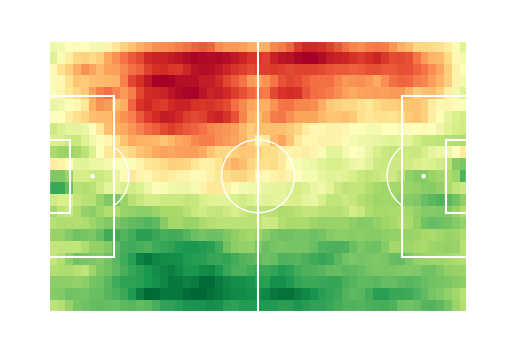

pass


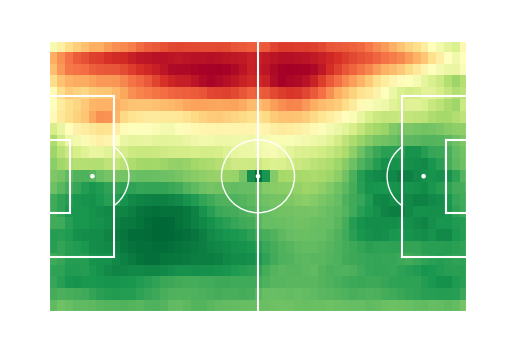

shot


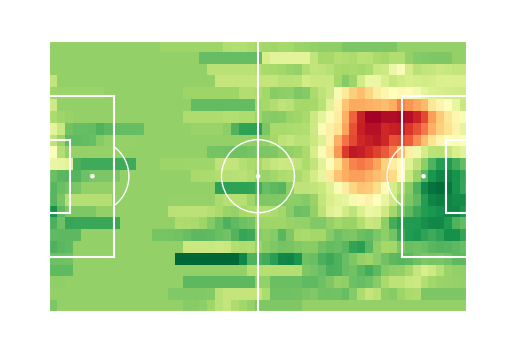

cross


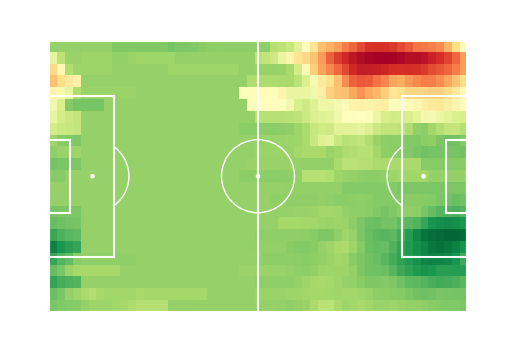

interception


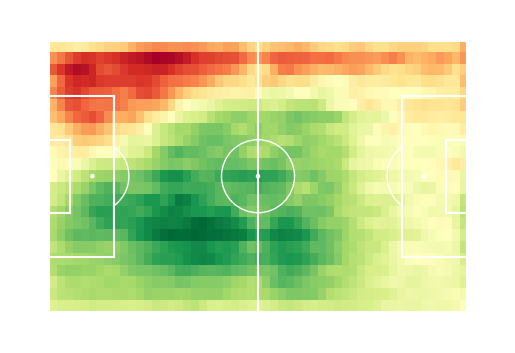

clearance


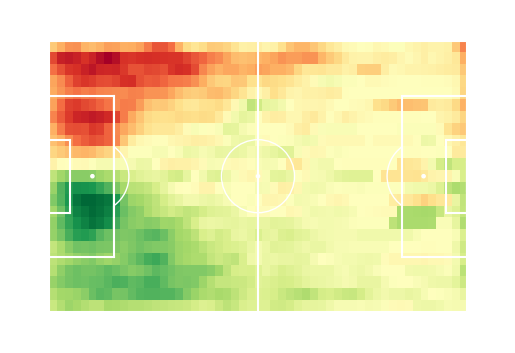

In [ ]:
print('heatmaps builded from AC Milan\'s profile')
draw_heatmaps_from_vector(team_vector_train[3157])

In [ ]:
df_player_vectors = pd.read_json(GDRIVE_DATA_DIR+'/player_feature_vectors.json')
dict_pl2vec = df_player_vectors.to_dict()
#pd.DataFrame(team_vectors).to_json(GDRIVE_DATA_DIR+'/team_feature_vectors.json')

#**Recommendation System**


In [ ]:
def get_recommendations(vec: np.array , k:int, knn: KNeighborsClassifier, labels: list) -> list:
  recommendations = list(knn.kneighbors([vec], n_neighbors=k)[1][0])
  return [labels[r] for r in recommendations]

def n_relevant_recommendations(team: int, k: int) -> int:
  recs = get_recommendations(team_vector_train[team],k ,knn,y)
  n_relevants = 0
  for r in recs:
    if team_vector_test[r]['team'] == team:
      n_relevants += 1
  return n_relevants

In [ ]:
training_data = sorted([(k, dict_pl2vec[k]['pca_feature_vector']) for k in dict_pl2vec.keys()], key= lambda x: x[0])
#test_data = sorted([(k, dict_pl2vec[k]['pca_decoded_vector']) for k in dict_pl2vec.keys()], key= lambda x: x[0])
X_train =[x[1] for x in training_data]
y_train = [x[0] for x in training_data]
#X_test =[x[1] for x in test_data]
#y_test = [x[0] for x in test_data]
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(X_train, y_train)

Detect similar player to Lionel Messi

In [ ]:
messi2vec = X_train[81]
df_players_vector_team[df_players_vector_team['wyId'].isin(get_recommendations(messi2vec,5,knn,y_train))]#[['wyId','currentTeamId','shortName']]

,shortName,wyId,currentTeamId,role_direct,player,pca,std_features,player_pass,pca_pass,std_features_pass,...,std_features_interception,player_clearance,pca_clearance,std_features_clearance,team_id,player_id,appearances,last_match_day,change_team,player_vector
113,L. Messi,3359,676,FW,3359,"[-5.8012859938, 22.1320665487, 28.4712829962, ...","[-0.056574560600000004, -0.0665869774, -0.0819...",3359,"[-7.4313118946, -25.7912484035, -55.1577377016...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",3359,"[7.7300532529, 1.1559384866, -0.044506873, 0.4...","[-0.11551546530000001, -0.1344703143, -0.15367...",676,3359.0,36,2018-05-20,0,"[-5.8012859938, 22.1320665487, 28.4712829962, ..."
600,L. Stindl,15051,2454,FW,15051,"[-1.2303473423, 5.0063974869, 4.4617677168, -2...","[-0.056574560600000004, -0.0665869774, -0.0819...",15051,"[-3.0632240783, -13.3234566675, -26.6472222932...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",15051,"[4.0652857922, -0.0578378674, -0.0201398321, 1...","[-0.11551546530000001, -0.1344703143, -0.15367...",2454,15051.0,27,2018-04-28,0,"[-1.2303473423, 5.0063974869, 4.4617677168, -2..."
825,G. Ram\u00edrez,20689,3164,MD,20689,"[-2.0052362995, 9.6947937435, 12.6273892229, 0...","[-0.056574560600000004, -0.0665869774, -0.0819...",20689,"[-3.9921545425, -14.2863784791, -21.8637264208...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",20689,"[4.3497711967, 1.9706449261999999, -0.22980482...","[-0.11551546530000001, -0.1344703143, -0.15367...",3164,20689.0,36,2018-05-20,0,"[-2.0052362995, 9.6947937435, 12.6273892229, 0..."
969,P. Dybala,89186,3159,FW,89186,"[-7.5870944693, 7.7490226437, 8.5414865992, -0...","[-0.056574560600000004, -0.0665869774, -0.0819...",89186,"[-8.9327501217, -15.3779233642, -29.772397365,...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",89186,"[7.2764957613, 0.5048652189, 0.1067375379, 0.3...","[-0.11551546530000001, -0.1344703143, -0.15367...",3159,89186.0,32,2018-05-19,0,"[-7.5870944693, 7.7490226437, 8.5414865992, -0..."
1391,E. Lamela,20441,1624,MD,20441,"[-4.8868325066, 12.6036728163, 9.1146428934, -...","[-0.056574560600000004, -0.0665869774, -0.0819...",20441,"[-6.6739982481, -20.6678515684, -33.3312108117...","[-0.22078603530000002, -0.2955905996, -0.34762...",...,"[-0.0938323591, -0.1303595589, -0.154677989700...",20441,"[7.4445789109, 0.1404513094, 0.076272886800000...","[-0.11551546530000001, -0.1344703143, -0.15367...",1624,20441.0,23,2018-05-13,0,"[-4.8868325066, 12.6036728163, 9.1146428934, -..."


For football fans and experts, is known that Messi and Dybala have similar playing style

Lionel Messi's heatmaps
dribble


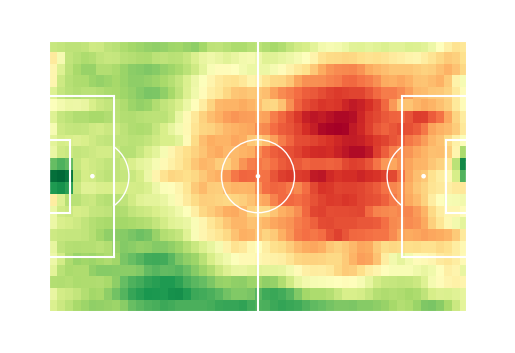

pass


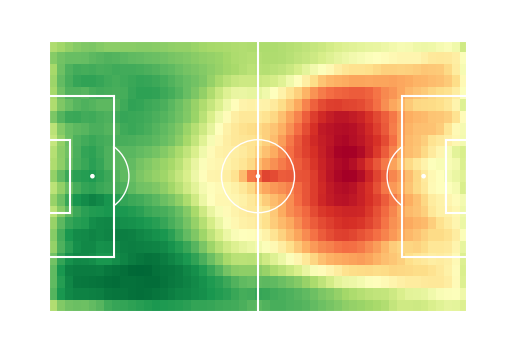

shot


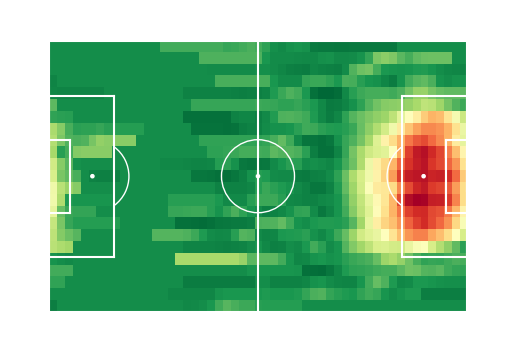

cross


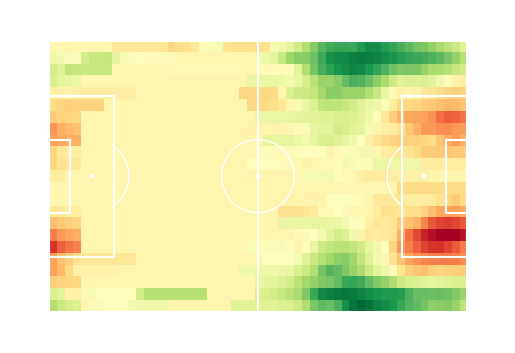

interception


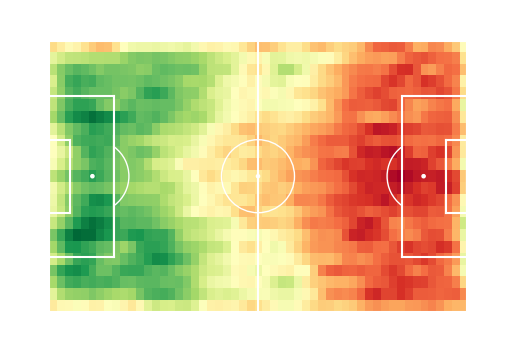

clearance


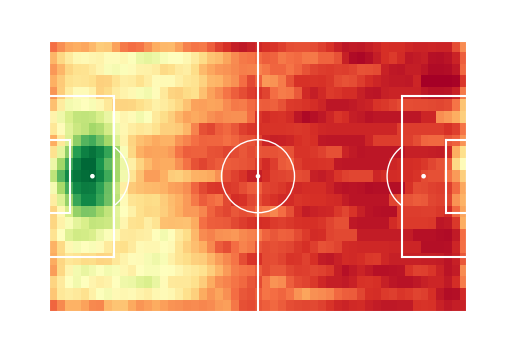

Paulo Dybala's heatmaps
dribble


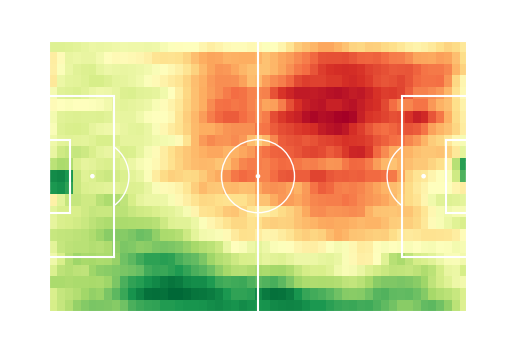

pass


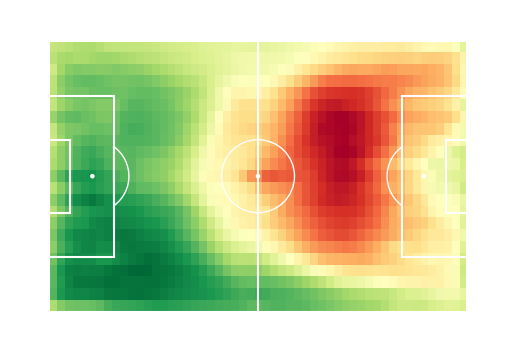

shot


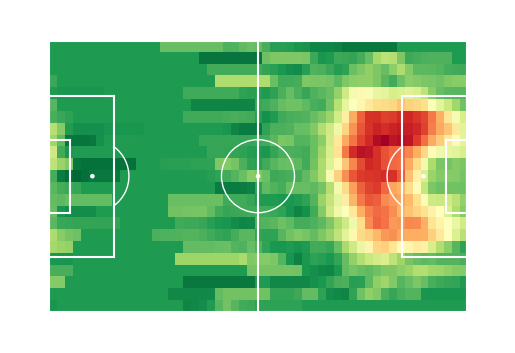

cross


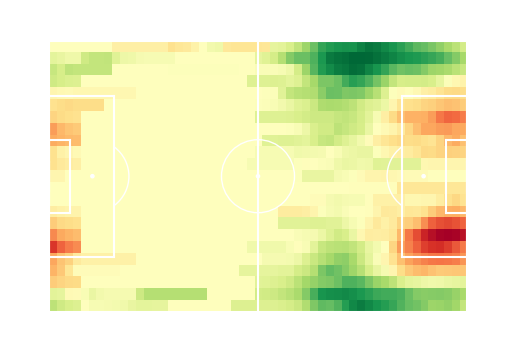

interception


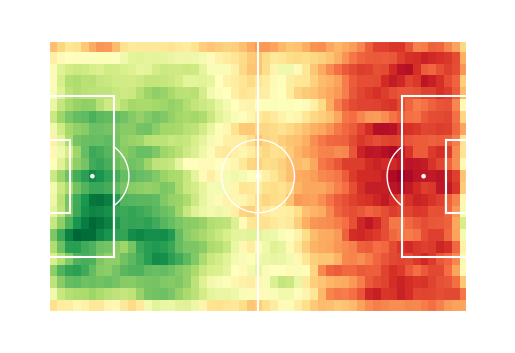

clearance


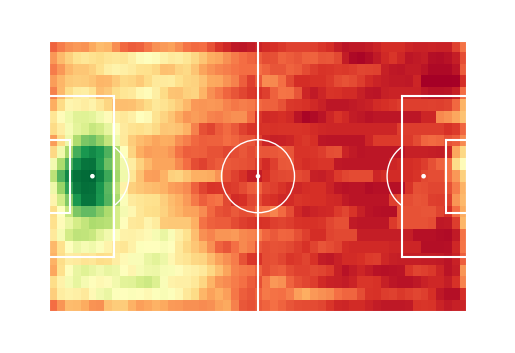

In [ ]:
dybala2vec= np.array(X_train[1032])
print('Lionel Messi\'s heatmaps')
draw_heatmaps_from_vector(np.array(messi2vec))
print('Paulo Dybala\'s heatmaps')
draw_heatmaps_from_vector(dybala2vec)

In [ ]:
X = []
y=[]
team_nrelevants = {}
for k, i in team_vector_test.items():
  y.append(k)
  X.append(team_vector_test[k]['vector'])
  if team_vector_test[k]['team'] not in team_nrelevants.keys():
    team_nrelevants[team_vector_test[k]['team']] = 1
  else:
    team_nrelevants[team_vector_test[k]['team']] = team_nrelevants[team_vector_test[k]['team']]+1

knn = KNeighborsClassifier(metric='cosine')
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print('First 20 recommendations for Manchester City')
df_players_vector_team[df_players_vector_team['wyId'].isin(get_recommendations(team_vector_train[1625],20,knn,y))][['shortName','wyId','role_direct','team_id']]

First 20 recommendations for Manchester City


,shortName,wyId,role_direct,team_id
5,C. Eriksen,54,MD,1624
106,Thiago Alc\u00e2ntara,3345,MD,2444
129,Koke,3443,MD,679
195,M. Kova\u010di\u0107,69404,MD,675
252,Jo\u00e3o Moutinho,70093,MD,19830
291,K. De Bruyne,38021,MD,1625
316,A. Zambo Anguissa,366401,MD,3771
368,Paulinho,40550,MD,676
382,P. Pogba,7936,MD,1611
396,Borja Valero,3543,MD,3161


In [ ]:
ratios = []
for i in team_nrelevants.keys():
    ratio = team_nrelevants[i] / len(X)
    ratios.append(ratio)

print(f'Average number of relevant players per team is {np.around(len(X)/len(team_ids),decimals= 2)}, in percent: {np.around(np.mean(ratios),decimals=4)*100}%')

Average number of relevant players per team is 4.27, in percent: 1.02%


In [ ]:
n_relevants = 0
for k in [20,30,50,100]:
  for team in team_ids:
    n_relevants+= n_relevant_recommendations(team,30)
  print(f'The recall@{k} is {np.around(n_relevants / len(X), decimals=2)}')
  print(f'The precision@{k} is {np.around(n_relevants / (k * len(team_ids)), decimals=2)}')
  print()

The recall@20 is 0.08
The precision@20 is 0.02

The recall@30 is 0.15
The precision@30 is 0.02

The recall@50 is 0.23
The precision@50 is 0.02

The recall@100 is 0.31
The precision@100 is 0.01



In [ ]:
for k in [20,30,50,100]:
  rec_players = set()
  for team in team_ids:
    recs = get_recommendations(team_vector_train[team],k,knn,y)
    rec_players = rec_players | set(recs)

  print(f'The coverage of the test set with {k} recommendations is {np.around(len(rec_players)/len(X), decimals=4)*100}')

The coverage of the test set with 20 recommendations is 92.34
The coverage of the test set with 30 recommendations is 96.17
The coverage of the test set with 50 recommendations is 99.52
The coverage of the test set with 100 recommendations is 100.0


In [ ]:
from scipy.spatial.distance import cosine

def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

for k in [20,30,50,100]:
  team_recs = {}
  rec_players = set()
  for team in team_ids:
    recs = get_recommendations(team_vector_train[team],k,knn,y)
    team_recs[team] = recs
    rec_players = rec_players | set(recs)

  binary_recs = {k: [] for k in team_recs.keys()}
  for pl in rec_players:
    for team in team_ids:
        binary_recs[team].append(1 if pl in team_recs[team] else 0)

  team_recs_similarity = {k: [] for k in binary_recs.keys()}
  for team in sorted(team_recs_similarity.keys()):
    x = binary_recs[team]
    for team1 in sorted(team_recs_similarity.keys()):
      x1 = binary_recs[team1]
      team_recs_similarity[team].append(1-cosine(x,x1))

  recs_similarity_matrix = np.stack(list(team_recs_similarity.values()))
  print(f'The personalization score on test set for {k} recommendations is {np.around(1 -np.mean(upper_tri_masking(recs_similarity_matrix)),decimals=2)}')

The personalization score on test set for 20 recommendations is 0.92
The personalization score on test set for 30 recommendations is 0.9
The personalization score on test set for 50 recommendations is 0.85
The personalization score on test set for 100 recommendations is 0.74


Verify personalization and coverage on entire dataset

In [ ]:
y_total = sorted(player_vectors.keys())
X_total = [player_vectors[k] for k in y_total]

knn_total = KNeighborsClassifier(metric='cosine')
knn_total.fit(X_total,y_total)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
for k in [20,30,50,100]:
  rec_players = set()
  for team in team_ids:
    recs = get_recommendations(team_vector[team],k,knn_total,y_total)
    rec_players = rec_players | set(recs)

  print(f'The coverage of the entire dataset with {k} recommendations is {np.around(len(rec_players)/len(X_total), decimals=4)*100}')

The coverage of the entire dataset with 20 recommendations is 52.470000000000006
The coverage of the entire dataset with 30 recommendations is 66.56
The coverage of the entire dataset with 50 recommendations is 82.09
The coverage of the entire dataset with 100 recommendations is 96.91


In [ ]:
for k in [20,30,50,100]:
  team_recs = {}
  rec_players = set()
  for team in team_ids:
    recs = get_recommendations(team_vector[team],k,knn_total,y_total)
    team_recs[team] = recs
    rec_players = rec_players | set(recs)

  binary_recs = {k: [] for k in team_recs.keys()}
  for pl in rec_players:
    for team in team_ids:
        binary_recs[team].append(1 if pl in team_recs[team] else 0)

  team_recs_similarity = {k: [] for k in binary_recs.keys()}
  for team in sorted(team_recs_similarity.keys()):
    x = binary_recs[team]
    for team1 in sorted(team_recs_similarity.keys()):
      x1 = binary_recs[team1]
      team_recs_similarity[team].append(1-cosine(x,x1))

  recs_similarity_matrix = np.stack(list(team_recs_similarity.values()))
  print(f'The personalization score on test set for {k} recommendations is {np.around(1 -np.mean(upper_tri_masking(recs_similarity_matrix)),decimals=2)}')

The personalization score on test set for 20 recommendations is 0.95
The personalization score on test set for 30 recommendations is 0.94
The personalization score on test set for 50 recommendations is 0.92
The personalization score on test set for 100 recommendations is 0.89
